In [1]:
import sys
import os
current_dir = os.getcwd()
root_dir = os.path.dirname(current_dir)
sys.path.insert(0, str(root_dir))

import spatialzoomer as sz

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

C:\Users\fyh\AppData\Roaming\Python\Python39\site-packages\networkx\utils\backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
adata = sc.read_h5ad("C:/Projects/SpatialZoomer/data/CosMx_Mouse_Brain_quarter_RAW_anndata.h5ad")
runLabel = 'CosMx_Mouse_Brain_quarter'
save_path = './results/' + runLabel+'_neighbor10_TEST'

<Axes: title={'center': 'Volume of segmented cells'}, xlabel='Area', ylabel='Count'>

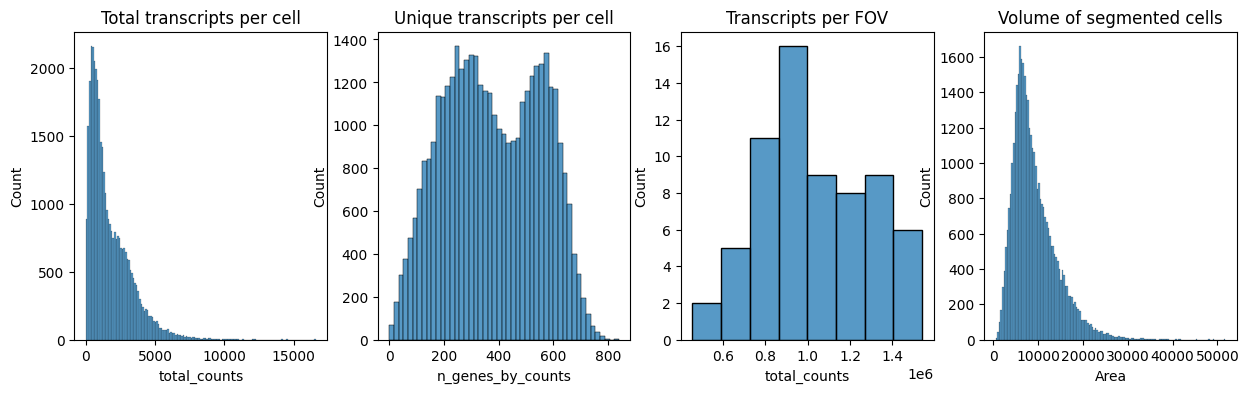

In [3]:
sc.pp.calculate_qc_metrics(adata, percent_top=(50, 100, 200, 300), inplace=True)
fig, axs = plt.subplots(1, 4, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)

axs[2].set_title("Transcripts per FOV")
sns.histplot(
    adata.obs.groupby("fov").sum()["total_counts"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Volume of segmented cells")
sns.histplot(
    adata.obs["Area"],
    kde=False,
    ax=axs[3],
)

In [4]:
sc.pp.filter_cells(adata, min_counts = 100)
sc.pp.filter_cells(adata, min_genes = 10)
sc.pp.filter_genes(adata, min_cells = 5)
adata = sz.Preprocess(adata)
adata

AnnData object with n_obs × n_vars = 38251 × 960
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.Histone', 'Max.Histone', 'Mean.G', 'Max.G', 'Mean.rRNA', 'Max.rRNA', 'Mean.GFAP', 'Max.GFAP', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_300_genes', 'n_counts', 'n_genes'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'spatial_fov', 'spatial_raw'
    layers: 'counts'

In [5]:
adata = sz.performDR(adata, type = 'NMF', n_components=50)

Time taken to perform NMF: 70.4716 seconds


In [6]:
sz_analyzer = sz.MultiscaleAnalysis(adata=adata, runLabel=runLabel, save_path=save_path)

# define scales
scales = [0.01] + np.arange(0.1, 2.1, 0.1).tolist() + np.arange(2.5, 15.5, 0.5).tolist() + np.arange(16, 21, 1).tolist() +  np.arange(25, 55, 5).tolist()
scales = [round(x, 2) for x in scales]

# if not passing the parameter scales, scales are automatically generated as above
sz_analyzer.multiscale_transform(use_rep='X_nmf', n_neighbors=10, scales=scales)

Maximum similarities:  45.642685249997946
Minimum similarities:  1.2569474955253868
Median similarities:  4.999999999980174
time taken to construct spatial_knn: 0.0938 seconds
Time taken to perform spectral graph filter bank: 18.1602 seconds
Transformed signals saved to ./results/CosMx_Mouse_Brain_quarter_neighbor10_TEST/CosMx_Mouse_Brain_quarter_transformed_signals.h5


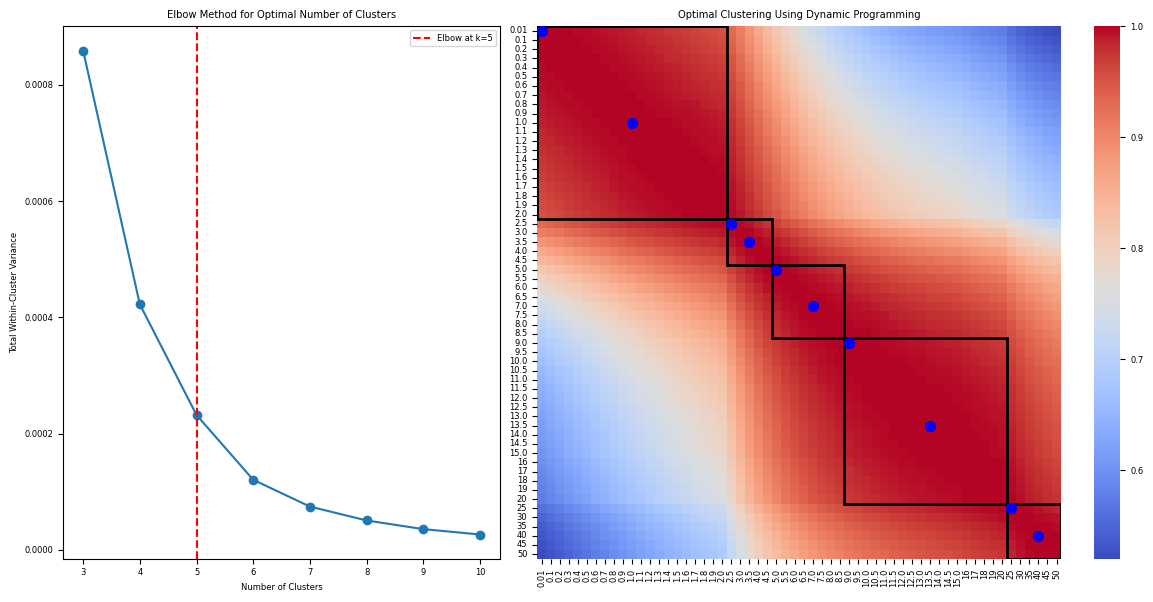

The optimal number of clusters is: 5
Optimal clusters (start, end): [(0, 20), (21, 25), (26, 33), (34, 51), (52, 57)]
Cluster centers: [1.0, 3.5, 7.0, 13.5, 40]
Typical scales: [0.01, 1.0, 2.5, 3.5, 5.0, 7.0, 9.0, 13.5, 25, 40]
Time taken to perform identification of typical scales: 2.8599 seconds


In [7]:
sz_analyzer.identify_typical_scales(max_clusters=10, min_clusters=3)

In [8]:
resolutions = [0.4, 0.8, 1.2]
sz_analyzer.clustering(n_clusters_kmeans=10000, resolutions=resolutions, min_scale=None, max_scale=20)

Time taken to perform UMAP and clustering for raw signal: 115.7725 seconds
Time taken to perform clustering for signal at scale 0.01: 109.5082 seconds
Time taken to perform clustering for signal at scale 1.0: 128.4467 seconds
Time taken to perform clustering for signal at scale 2.5: 96.6515 seconds
Time taken to perform clustering for signal at scale 3.5: 108.4155 seconds
Time taken to perform clustering for signal at scale 5.0: 145.5859 seconds
Time taken to perform clustering for signal at scale 7.0: 176.1547 seconds
Time taken to perform clustering for signal at scale 9.0: 181.1791 seconds
Time taken to perform clustering for signal at scale 13.5: 167.4274 seconds
Total time: 1113.3898 seconds


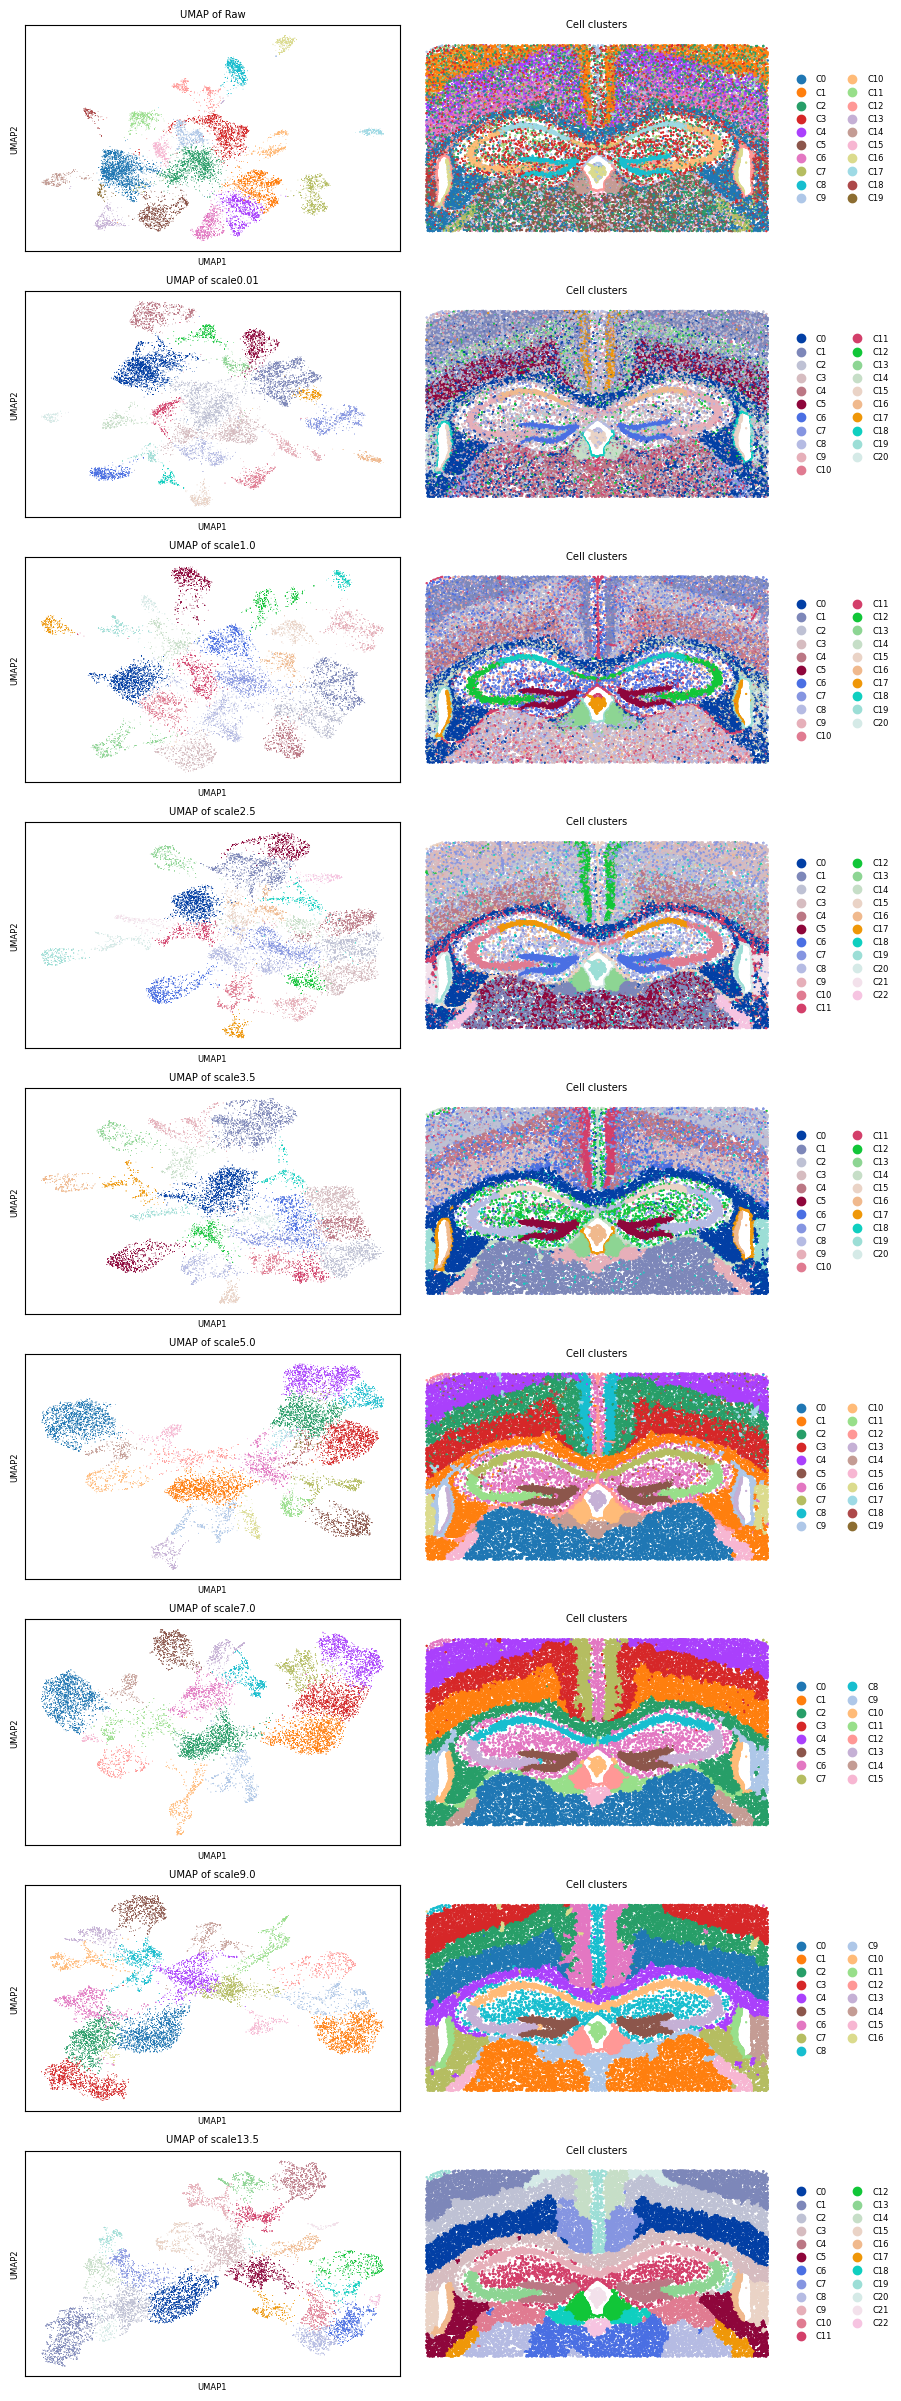

In [9]:
sz_analyzer.plot_multiscale_clusters(resolution=0.8)

Maximum similarities:  1972.0965922189623
Minimum similarities:  208.47349002481096
Median similarities:  505.8174846544358
time taken to construct expr_knn: 0.7145 seconds


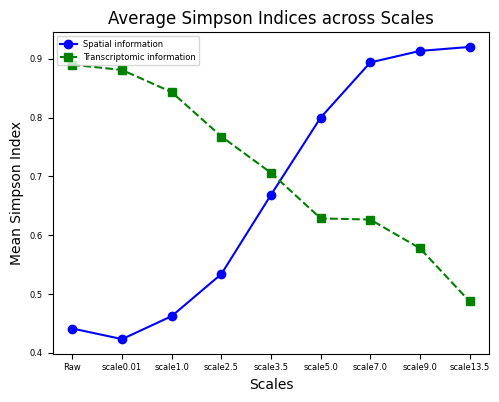

In [10]:
sz_analyzer.plot_simpson()

In [11]:
sz_analyzer.adata.write(save_path + '/CosMx_Mouse_Brain_quarter_multiscale.h5ad')